# Data Preprocessing

In [1]:
import pandas as pd
import random
from hazm import Normalizer

def clean_persian_text(text):
    normalizer = Normalizer()
    return normalizer.normalize(text)

def load_and_process_data(file_path):
    try:
        csv_dataset = pd.read_csv(file_path)
        reviews = [(clean_persian_text(text), sentiment) for text, sentiment in zip(csv_dataset['Text'], csv_dataset['Sentiment'])]
        return reviews
    except FileNotFoundError:
        print("File not found. Please check the file path.")
        return []

def filter_reviews_by_sentiment(reviews, sentiment):
    return [review for review in reviews if review[1] == sentiment]

def print_random_sample(reviews, sentiment):
    if reviews:
        print(f"{sentiment} sample : \n", random.choice(reviews))
    else:
        print(f"No {sentiment} reviews available.")


file_path = "Raw_Dataset_97P_107.csv"
reviews = load_and_process_data(file_path)

positive_reviews = filter_reviews_by_sentiment(reviews, "positive")
negative_reviews = filter_reviews_by_sentiment(reviews, "negative")
neutral_reviews = filter_reviews_by_sentiment(reviews, "neutral")

balanced_reviews = positive_reviews[:2500] + negative_reviews[:2500]
random.shuffle(balanced_reviews)

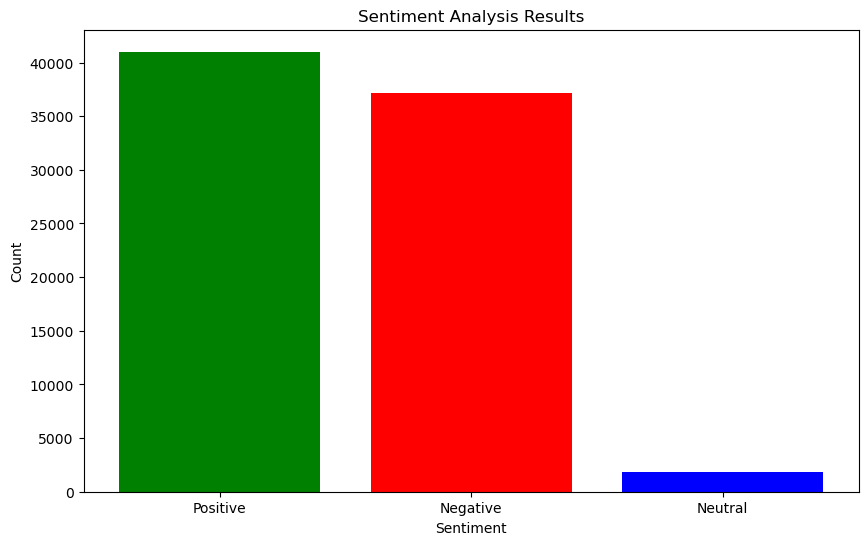


Random Samples:
Positive sample : 
 ('متاسفانه بجای ۵ نان ساده، چهار نان کنجدی برا من آورد. ولی کیفیت نان خوب بود', 'positive')
Positive Sample: None
Negative sample : 
 ('برخلاف سفارشات قبلی، اینبار بسیار مونده بود و حتی داخل ران مرغ\u200cها کاملا سیاه بود، واقعا توقع کیفیت تا این حد پایین رو از مهدی نداشتم.', 'negative')
Negative Sample: None
Neutral sample : 
 ('سلام من از دیجی کالا خرید کردم شگفت انگیز شده بود چیزی که تو سایت هست رو ندیدم داخل دوربین حتما داخل تنظیمات برید باید ۶۰فریم بر ثانیه فیلم برداری کنه اگر نداشت تقلبی هست زومش هم دقیقا زوم دوربین قبلی یعنی sx۷۰۰ هست درضمن بهم گفتن قرمزاش اصلیه و قویتر ', 'neutral')
Neutral Sample: None

Balanced dataset count: 5000


In [2]:
import matplotlib.pyplot as plt

# Count of each sentiment category
sentiment_counts = {
    "Positive": len(positive_reviews),
    "Negative": len(negative_reviews),
    "Neutral": len(neutral_reviews),
}

# Total count of reviews
total_count = len(reviews)

# Display counts in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['green', 'red', 'blue'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Analysis Results")
plt.show()

# Display random samples
print("\nRandom Samples:")
print(f"Positive Sample: {print_random_sample(positive_reviews, 'Positive')}")
print(f"Negative Sample: {print_random_sample(negative_reviews, 'Negative')}")
print(f"Neutral Sample: {print_random_sample(neutral_reviews, 'Neutral')}")

# Display count of the balanced dataset
print(f"\nBalanced dataset count: {len(balanced_reviews)}")

# Data Preparation for Text Classification

In [3]:
import numpy as np
from keras import backend as K

VECTOR_SIZE = 300  # Dimension of the vectors
MAX_NO_TOKENS = 107  # Maximum number of tokens
TRAIN_TEST_SPLIT = 0.8  # Proportion of the data to be used for training

def split_data(data, train_test_split):
    train_size = int(train_test_split * len(data))
    test_size = len(data) - train_size
    return train_size, test_size

def initialize_arrays(train_size, test_size, max_tokens, VECTOR_SIZE):
    x_train = np.zeros((train_size, max_tokens, VECTOR_SIZE), dtype=K.floatx())
    y_train = np.zeros((train_size, 2), dtype=np.int32)

    x_test = np.zeros((test_size, max_tokens, VECTOR_SIZE), dtype=K.floatx())
    y_test = np.zeros((test_size, 2), dtype=np.int32)

    return x_train, y_train, x_test, y_test

train_size, test_size = split_data(balanced_reviews, TRAIN_TEST_SPLIT)
x_train, y_train, x_test, y_test = initialize_arrays(train_size, test_size, MAX_NO_TOKENS, VECTOR_SIZE)

2024-01-28 07:58:08.210628: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 07:58:08.210656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 07:58:08.266738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 07:58:08.344092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import tabulate

# Shapes of the arrays
shapes_data = [
    ["x_train", x_train.shape],
    ["x_test", x_test.shape],
    ["y_train", y_train.shape],
    ["y_test", y_test.shape]
]

# Display vocabulary size and array shapes in a table
table = tabulate.tabulate(shapes_data, headers=["Item", "Shape/Size"], tablefmt="fancy_grid")
print("Data Information:")
print(table)

Data Information:
╒═════════╤══════════════════╕
│ Item    │ Shape/Size       │
╞═════════╪══════════════════╡
│ x_train │ (4000, 107, 300) │
├─────────┼──────────────────┤
│ x_test  │ (1000, 107, 300) │
├─────────┼──────────────────┤
│ y_train │ (4000, 2)        │
├─────────┼──────────────────┤
│ y_test  │ (1000, 2)        │
╘═════════╧══════════════════╛


# Text Vectorization and Sentiment Classification

In [6]:
import numpy as np
import fasttext
import hazm

def load_fasttext_model(model_path):
    return fasttext.load_model(model_path)

def tokenize_text(text, tokenizer, max_tokens):
    return tokenizer.tokenize(text)[:max_tokens]

def vectorize_text(text, model, max_tokens):
    return [model.get_word_vector(word) for word in text if word in model.words][:max_tokens]

def process_reviews(reviews, model, tokenizer, max_tokens, label_map):
    x_data = []
    y_data = []
    unique_words = set()

    for text, sentiment in reviews:
        tokenized_text = tokenize_text(text, tokenizer, max_tokens)
        unique_words.update(tokenized_text)
        vectorized_text = vectorize_text(tokenized_text, model, max_tokens)

        if not vectorized_text:
            continue

        padded_vector = np.zeros((max_tokens, model.get_dimension()), dtype=np.float32)
        padded_vector[:len(vectorized_text), :] = vectorized_text

        x_data.append(padded_vector)
        y_data.append(label_map.get(sentiment, label_map['other']))

    return np.array(x_data), np.array(y_data), len(unique_words)

# Load model and tokenizer
W2V_Model = load_fasttext_model("Facebook_Embedding_Model_300.bin")
tokenizer = hazm.WordTokenizer()

# Assuming 'balanced_reviews' is a list of (text, sentiment) tuples
all_reviews = balanced_reviews  # Use the complete set of reviews
train_reviews = balanced_reviews[:train_size]
test_reviews = balanced_reviews[train_size:]

# Define a mapping for sentiment to binary labels
sentiment_label_map = {"negative": [1.0, 0.0], 'other': [0.0, 1.0]}  # Adjust based on actual labels

x_train, y_train, vocabulary_size = process_reviews(train_reviews, W2V_Model, tokenizer, MAX_NO_TOKENS, sentiment_label_map)
x_test, y_test, _ = process_reviews(test_reviews, W2V_Model, tokenizer, MAX_NO_TOKENS, sentiment_label_map)

In [7]:
import tabulate

# Shapes of the arrays
shapes_data = [
    ["x_train", x_train.shape],
    ["x_test", x_test.shape],
    ["y_train", y_train.shape],
    ["y_test", y_test.shape]
]

# Display vocabulary size and array shapes in a table
table = tabulate.tabulate(shapes_data, headers=["Item", "Shape/Size"], tablefmt="fancy_grid")
print("Data Information:")
print(table)

Data Information:
╒═════════╤══════════════════╕
│ Item    │ Shape/Size       │
╞═════════╪══════════════════╡
│ x_train │ (4000, 107, 300) │
├─────────┼──────────────────┤
│ x_test  │ (1000, 107, 300) │
├─────────┼──────────────────┤
│ y_train │ (4000, 2)        │
├─────────┼──────────────────┤
│ y_test  │ (1000, 2)        │
╘═════════╧══════════════════╛


# Saving Data and Cleaning Resources

In [ ]:
np.save("x_train_Facebook_Small.npy", x_train)
np.save("x_test_Facebook_Small.npy", x_test)
np.save("y_train_Facebook_Small.npy", y_train)
np.save("y_test_Facebook_Small.npy", y_test)
del W2V_Model

# Data Loading and Main Configuration

In [1]:
import fasttext
import hazm
import numpy as np
from keras import backend as K
import pandas as pd
import random
from hazm import Normalizer

VECTOR_SIZE = 300  # Dimension of the vectors
MAX_NO_TOKENS = 107  # Maximum number of tokens

BATCH_SIZE = 512
NUM_EPOCHS = 100

x_train = np.load("./Facebook_Dataset/x_train_Facebook.npy")[:4000, :, :]
x_test = np.load("./Facebook_Dataset/x_test_FaceBook.npy" )[:1000, :, :]

y_train = np.load("./Facebook_Dataset/y_train_Facebook.npy")[:4000, :]
y_test = np.load("./Facebook_Dataset/y_test_Facebook.npy")[:1000, :]

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

2024-01-28 08:02:57.196414: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 08:02:57.196443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 08:02:57.197229: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 08:02:57.202250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(4000, 107, 300) (1000, 107, 300) (4000, 2) (1000, 2)


# Convolutional Neural Network (CNN) Model Definition

In [2]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, Input, Concatenate, Flatten
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Multiply

# Define the input layer for the neural network
input_layer = Input(shape=(MAX_NO_TOKENS, VECTOR_SIZE))

# Create convolutional layers with different kernel sizes
conv1 = Conv1D(filters=64, kernel_size=2, activation='relu', kernel_regularizer=l2(0.005))(input_layer)
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.005))(input_layer)
conv3 = Conv1D(filters=64, kernel_size=4, activation='relu', kernel_regularizer=l2(0.005))(input_layer)

# Perform global max pooling on each convolutional layer
pool1 = GlobalMaxPooling1D()(conv1)
pool2 = GlobalMaxPooling1D()(conv2)
pool3 = GlobalMaxPooling1D()(conv3)

# Concatenate the pooled features from different kernel sizes
concat = Concatenate()([pool1, pool2, pool3])

# Resize concatenated features to match attention probabilities
resize_concat = Dense(3, activation='relu')(concat)

# Implement an attention mechanism
attention_probs = Dense(3, activation='softmax', name='attention_probs')(resize_concat)
attention_mul = Multiply()([resize_concat, attention_probs])

# Add a dense layer with regularization
dense = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(attention_mul)
dropout = Dropout(0.5)(dense)

# Define the output layer
output = Dense(2, activation='softmax')(dropout)

# Build the neural network model
model = Model(inputs=input_layer, outputs=output)

# Compile the model with specified optimizer and loss function
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define callbacks for training
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Display a summary of the model architecture
model.summary()

2024-01-28 08:03:10.779108: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 08:03:11.047671: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 08:03:11.047896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 107, 300)]           0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 106, 64)              38464     ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 105, 64)              57664     ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 104, 64)              76864     ['input_1[0][0]']             
                                                                                              

In [3]:
from tensorflow.keras.callbacks import CSVLogger

# Filepath to save the CSV log
csv_logger_filepath = 'CNN_Small_Facebook_Result.csv'

# Create CSVLogger callback
csv_logger = CSVLogger(csv_logger_filepath, append=True)

# Fit the model
history = model.fit(
    x_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=NUM_EPOCHS, 
    shuffle=True, 
    validation_data=(x_test, y_test),
    callbacks=[reduce_lr, csv_logger]
)

2024-01-28 08:03:11.680018: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 513600000 exceeds 10% of free system memory.
2024-01-28 08:03:12.158867: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 513600000 exceeds 10% of free system memory.


Epoch 1/100


2024-01-28 08:03:13.836302: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65740800 exceeds 10% of free system memory.
2024-01-28 08:03:13.836361: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65740800 exceeds 10% of free system memory.
2024-01-28 08:03:13.836415: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65740800 exceeds 10% of free system memory.
2024-01-28 08:03:14.052155: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
2024-01-28 08:03:16.558683: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8088404d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-28 08:03:16.558709: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 with Max-Q Design, Compute Capability 6.1
2024-01-28 08:03:16.586166: I tensorflow/compiler/mlir/tensorflow/utils/dump_m

8/8 [==============================] - 12s 607ms/step - loss: 2.1068 - accuracy: 0.5055 - val_loss: 1.8560 - val_accuracy: 0.5090 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 1s 96ms/step - loss: 1.6989 - accuracy: 0.5128 - val_loss: 1.5076 - val_accuracy: 0.5090 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 1s 95ms/step - loss: 1.3908 - accuracy: 0.5125 - val_loss: 1.2506 - val_accuracy: 0.5090 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 1s 96ms/step - loss: 1.1661 - accuracy: 0.5132 - val_loss: 1.0663 - val_accuracy: 0.5090 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 1s 98ms/step - loss: 1.0066 - accuracy: 0.5280 - val_loss: 0.9375 - val_accuracy: 0.5090 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 1s 99ms/step - loss: 0.8944 - accuracy: 0.5525 - val_loss: 0.8463 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 7/100
8/8 [==============================] - 1s 96ms/step - loss: 0.8133 - accuracy: 0

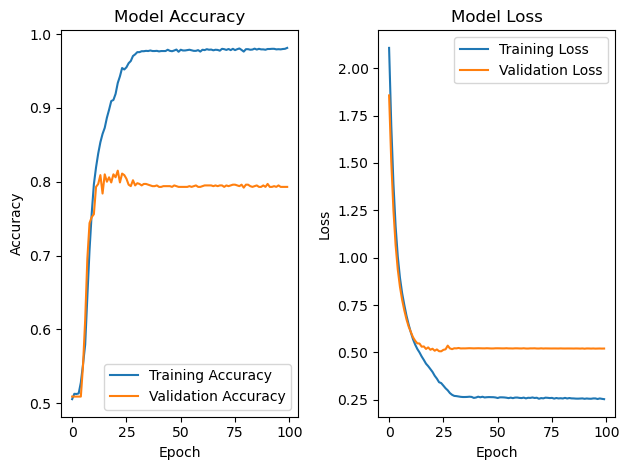

In [4]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable that contains your model training history.
# Replace 'history' with the actual name of the variable if it's different.

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [5]:
model.evaluate(x=x_test, y=y_test, batch_size=32, verbose=1)

2024-01-28 08:04:40.976927: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-28 08:04:41.026347: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


31/32 [============================>.] - ETA: 0s - loss: 0.5214 - accuracy: 0.7923

2024-01-28 08:04:41.427874: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-28 08:04:41.468166: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


32/32 [==============================] - 1s 13ms/step - loss: 0.5209 - accuracy: 0.7930


[0.520879328250885, 0.7929999828338623]

In [6]:
model.save('CNN_Small_Facebook_80P.model')

INFO:tensorflow:Assets written to: CNN_Small_Facebook_80P.model/assets


INFO:tensorflow:Assets written to: CNN_Small_Facebook_80P.model/assets


# Model Loading and Configuration

In [4]:
import fasttext
import hazm
import numpy as np
from keras import backend as K
import pandas as pd
import random
from hazm import Normalizer
from tensorflow.keras.models import load_model

VECTOR_SIZE = 300  # Dimension of the vectors
MAX_NO_TOKENS = 107  # Maximum number of tokens

model = load_model("CNN_Small_Facebook_80P.model")
W2V_Model = fasttext.load_model("Facebook_Embedding_Model_300.bin")

In [8]:
import numpy as np
import hazm
from keras import backend as K
from IPython.display import display, HTML
import ipywidgets as widgets
from IPython.display import clear_output

# Define the function for normalization and tokenization
def normalize_and_tokenize(text):
    normalizer = hazm.Normalizer()
    return hazm.word_tokenize(normalizer.normalize(text))

# Define the function for vectorizing text
def vectorize_text(words, model, max_tokens, vector_size):
    vectors = [model.get_word_vector(word) for word in words if word in model.words][:max_tokens]
    x_vectors = np.zeros((1, max_tokens, vector_size), dtype=K.floatx())
    x_vectors[0, :len(vectors), :] = vectors
    return x_vectors

# Define the function to display sentiment analysis results
def display_sentiment(result, images_src_path='./Assets/Images/'):
    pos_percent = f"{int(result[0][1] * 100)} % "
    neg_percent = f"{int(result[0][0] * 100)} % "
    html_content = f"<div style='text-align: center'><div style='display:inline-block'><img height='64px' width='64px' src='{images_src_path}smile.png'/><h4>{pos_percent}</h4></div> | <div style='display:inline-block'><img height='64px' width='64px' src='{images_src_path}angry.png'/><h4>{neg_percent}</h4></div></div>"
    display(HTML(html_content))

# Callback function to process and display results
def on_text_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        user_text = change['new']
        if user_text:
            tokenized_text = normalize_and_tokenize(user_text)
            x_text_vectors = vectorize_text(tokenized_text, W2V_Model, MAX_NO_TOKENS, VECTOR_SIZE)
            result = model.predict(x_text_vectors)  # Replace 'model' with your trained model
            display_sentiment(result)
        else:
            print("Please enter your text")

# Create a text input widget
text_input = widgets.Text(
    value='',
    placeholder='Type something',
    description='Input:',
    continuous_update=False,  # Set to False to trigger the event only when the user stops typing
    disabled=False
)

# Display the text input widget
display(text_input)

# Set the callback function for text input
text_input.observe(on_text_change, names='value')


Text(value='', continuous_update=False, description='Input:', placeholder='Type something')